# Pointwise analysis

In [1]:
import os
import sys
from pathlib import Path

from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pp5
import pp5.parallel

os.chdir(pp5.PROJECT_DIR)

## Loading the data

In [2]:
COLLECTION_DIR = Path('out/pgroup-collected/20200510_173642-violeta-p32r18')
POINTWISE_PATH = COLLECTION_DIR.joinpath('data-pointwise.csv')

OUT_DIR = COLLECTION_DIR.joinpath('results')
os.makedirs(OUT_DIR, exist_ok=True)


def pointwise_col_filter(col_name):
    return False if '+1' in col_name else True

df_pointwise_full = pd.read_csv(
    str(POINTWISE_PATH), usecols=pointwise_col_filter
)

We need to consolidate SS types (sometimes we have multiple SS types per
group) and then keep only rows where $S_{-1} = S_{+0}$.

In [3]:
DSSP_TO_SS_TYPE = {
    'E': 'SHEET',
    'H': 'HELIX',
    'G': 'HELIX',
    'I': 'HELIX',
    'T': 'TURN'
}

def pointwise_ss_consolidate(row: pd.Series, strict=False):
    ss_m1 = row['secondary-1']  # can be e.g. 'H' or e.g. 'H/G'
    ss_p0 = row['secondary+0']

    # In strict mode we require that all group members had the same SS, i.e.
    # we don't allow groups with more than one type.
    if strict and (len(ss_p0) != 1 or len(ss_m1) != 1):
        return None

    # The first SS type is always the reference SS type, so we compare those
    # If they match, this is the SS type of the pair
    # Otherwise this row is useless for us
    ss_m1 = DSSP_TO_SS_TYPE.get(ss_m1[0], 'OTHER')
    ss_p0 = DSSP_TO_SS_TYPE.get(ss_p0[0], 'OTHER')
    if ss_m1 == ss_p0:
        return ss_m1

    return None

ss_consolidated = df_pointwise_full.apply(pointwise_ss_consolidate, axis=1)

Keep only what we need from the data and add the consolidated secondary
structure.

In [4]:
angle_cols = ['phi+0', 'psi+0', 'psi-1',]
codon_cols = ['codon+0', 'codon-1']
secondary_col = 'secondary'

df_pointwise = pd.DataFrame(
    data=df_pointwise_full[angle_cols + codon_cols],
)
df_pointwise[secondary_col] = ss_consolidated

# Remove rows without consolidated SS (this means the residues didn't have
# the same SS)
has_ss = ~df_pointwise['secondary'].isnull()
df_pointwise = df_pointwise[has_ss]

# Convert dtype of angle columns
dtype = {}
for c in angle_cols:
    dtype[c] = np.float32
df_pointwise = df_pointwise.astype(dtype)

df_pointwise

,phi+0,psi+0,psi-1,codon+0,codon-1,secondary
0,-95.050003,6.410000,-18.450001,GCC,ATC,TURN
2,-72.699997,128.929993,45.930000,ATC,GAC,OTHER
3,-108.889999,102.669998,128.929993,GAC,ATC,OTHER
5,-81.089996,-8.770000,-12.580000,ACC,ATC,TURN
8,-66.519997,-32.060001,-32.330002,GAG,CCC,HELIX
...,...,...,...,...,...,...
1080329,-139.449997,138.850006,141.020004,GAA,TAT,SHEET
1080330,-121.129997,132.949997,138.850006,AGA,GAA,SHEET
1080331,-141.860001,132.770004,132.949997,GCA,AGA,SHEET
1080332,-142.250000,126.440002,132.770004,GAG,GCA,SHEET


## Dihedral angle distribution by secondary structure

We'll group the pointwise data by it's (consolidated) sencondary structure.
Then we'll plot a Ramachandran plot with the distribution of dihedral
angles, first a regular Ramachandran with both dihedral angles from the
same residue, and then using the cross-peptide angles $\varphi_0,\psi_{-1}$.

In [5]:
df_groups = df_pointwise.groupby(by=secondary_col)
group_idxs = [i for i, _ in df_groups]
df_groups.count()

,phi+0,psi+0,psi-1,codon+0,codon-1
secondary,,,,,
HELIX,364166,364165,364165,364169,364169
OTHER,228041,228045,228042,228055,228055
SHEET,184989,184987,184989,184989,184989
TURN,62982,62982,62982,62982,62982


Compute kernel-density estimate of the dihedral angles for each SS type.


In [6]:
from pp5.dihedral import DihedralKDE

def calc_ddist_group(group_data):
    group_idx, df_group = group_data
    phi_psi = df_group[angle_cols].values
    phi_psi = np.deg2rad(phi_psi)

    phi_p0 = phi_psi[:, 0]
    psi_p0 = phi_psi[:, 1]
    psi_m1 = phi_psi[:, 2]

    kde = DihedralKDE(n_bins=128, k1=30, k2=30, k3=0)
    P_p0 = kde(phi_p0, psi_p0)
    P_m1 = kde(phi_p0, psi_m1)
    return group_idx, (P_p0, P_m1)

In [7]:
with pp5.parallel.pool('test', context='fork') as pool:
    mapres = pool.map(calc_ddist_group, df_groups)

group_kdes = {group_idx: kdes for (group_idx, kdes) in mapres}

[2020-05-17 00:30:48,973         pp5.parallel]    INFO >> Starting pool test with 8 processes
[2020-05-17 00:30:48,991         pp5.parallel]    INFO >> Worker process 41673 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41673...
[2020-05-17 00:30:48,995         pp5.parallel]    INFO >> Worker process 41674 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41674...
[2020-05-17 00:30:49,001         pp5.parallel]    INFO >> Worker process 41675 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41675...
[2020-05-17 00:30:49,007         pp5.parallel]    INFO >> Worker process 41676 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41676...
[2020-05-17 00:30:49,013         pp5.parallel]    INFO >> Worker process 41677 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41677...
[2020-05-17 00:30:49,019         pp5.parallel]    INFO >> Worker process 41678 using dir /var/folders

Create Ramachandran plots, with the cross-peptide on top of the regular plot.

Text(0.5, 0.98, 'Dihedral distribution by SS')

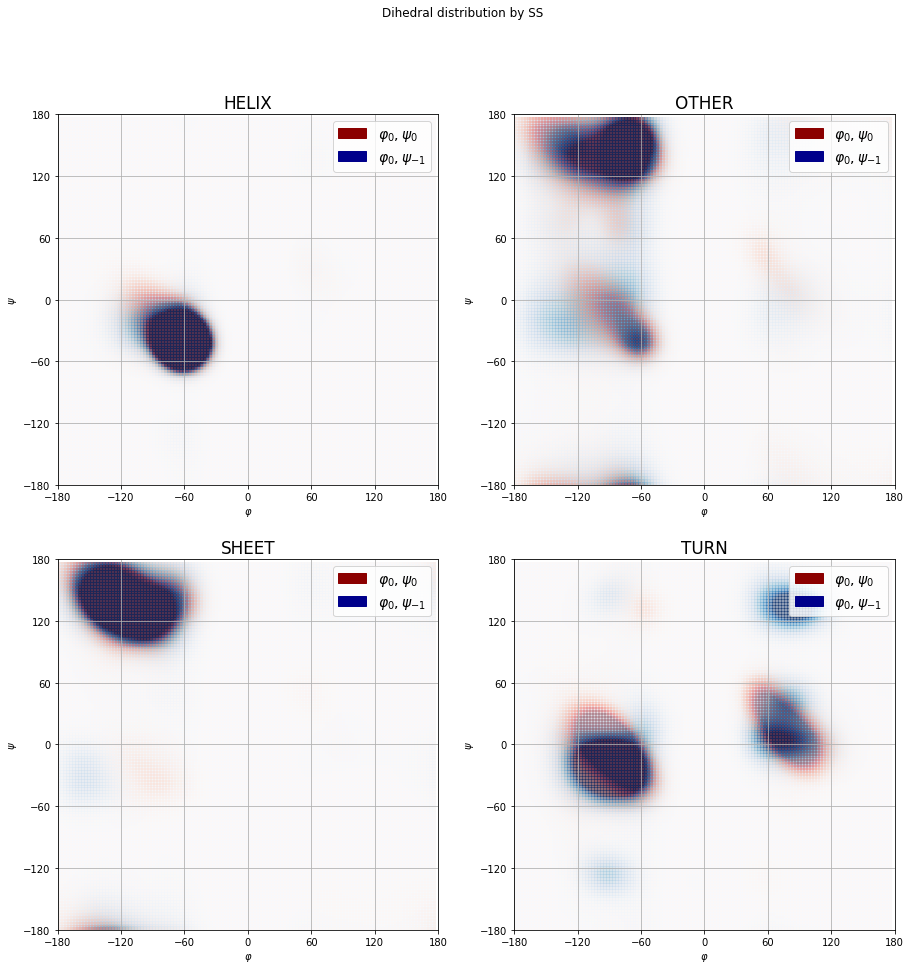

In [8]:
import pp5.plot as plot

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.reshape(-1)

vmin, vmax = 0., 5e-4
labels = [r'$\varphi_0, \psi_0$', r'$\varphi_0, \psi_{-1}$']
for i, group_idx in enumerate(group_idxs):
    P_p0, P_m1 = group_kdes[group_idx]
    plot.ramachandran([P_p0, P_m1], labels, title=group_idx, ax=ax[i],
                      vmax=vmax, vmin=vmin)

fig.suptitle('Dihedral distribution by SS')
# fig.savefig(OUT_DIR.joinpath('ddist_full.png'), dpi=150)

## Bi-codon distance matrices

- Group by prev codon and secondary SS
- In each group, compute P for each current codon and pairwise distances
between each two

In [15]:
df_groups = df_pointwise.groupby(by=['codon-1', 'secondary'])
group_idxs = [i for i, _ in df_groups]
df_groups.count()

phi+0  psi+0  psi-1  codon+0
codon-1 secondary                              
AAA     HELIX      11740  11740  11740    11740
        OTHER       6441   6441   6441     6441
        SHEET       4265   4265   4265     4265
        TURN        2366   2366   2366     2366
AAC     HELIX       6086   6086   6086     6086
...                  ...    ...    ...      ...
TTG     TURN         541    541    541      541
TTT     HELIX       6130   6130   6130     6130
        OTHER       3951   3951   3951     3951
        SHEET       4680   4680   4680     4680
        TURN         762    762    762      762

[244 rows x 4 columns]

In [11]:
with pp5.parallel.pool('test', context='fork', processes=16) as pool:
    for group_idx, df_group in df_groups:
        df_subgroups = df_group.groupby('codon+0')

        mapres = pool.map(calc_ddist_group, df_subgroups)
        subgroup_kdes = {group_idx: kdes for (group_idx, kdes) in mapres}

        # fig, ax = plt.subplots(8, 8, figsize=(64, 64))
        # ax = np.reshape(ax, -1)

        print(f'Processed group {group_idx}, group_size={len(df_group)}, '
              f'subgroup_size={len(subgroup_kdes)}')
        # for i, (subgroup_idx, subgroup_pdists) in enumerate(subgroup_kdes.items()):
        #     plot.ramachandran(subgroup_pdists, labels, title=subgroup_idx, ax=ax[i])
        #
        # fig.tight_layout()
        # outfile = OUT_DIR.joinpath('ddist').joinpath(f'{group_idx[1]}').joinpath(f'{group_idx[0]}.png')
        # os.makedirs(str(outfile.parent), exist_ok=True)
        # fig.savefig(str(outfile), dpi=200)
        # plt.close()
        # print(f'Wrote {outfile})')

[2020-05-17 00:41:16,062         pp5.parallel]    INFO >> Starting pool test with 16 processes
[2020-05-17 00:41:16,079         pp5.parallel]    INFO >> Worker process 41755 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41755...
[2020-05-17 00:41:16,082         pp5.parallel]    INFO >> Worker process 41756 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41756...
[2020-05-17 00:41:16,088         pp5.parallel]    INFO >> Worker process 41757 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41757...
[2020-05-17 00:41:16,095         pp5.parallel]    INFO >> Worker process 41758 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41758...
[2020-05-17 00:41:16,102         pp5.parallel]    INFO >> Worker process 41759 using dir /var/folders/cy/jr9f_bmd7h1dnjxr3pvrw_p80000gn/T/pp5_data/test/41759...
[2020-05-17 00:41:16,109         pp5.parallel]    INFO >> Worker process 41760 using dir /var/folder

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

In [63]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [82]:

from Bio.Data.CodonTable import standard_dna_table
print(standard_dna_table)
CODONS = sorted(standard_dna_table.forward_table)
CODONS = [f'X-{c}' for c in CODONS]

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

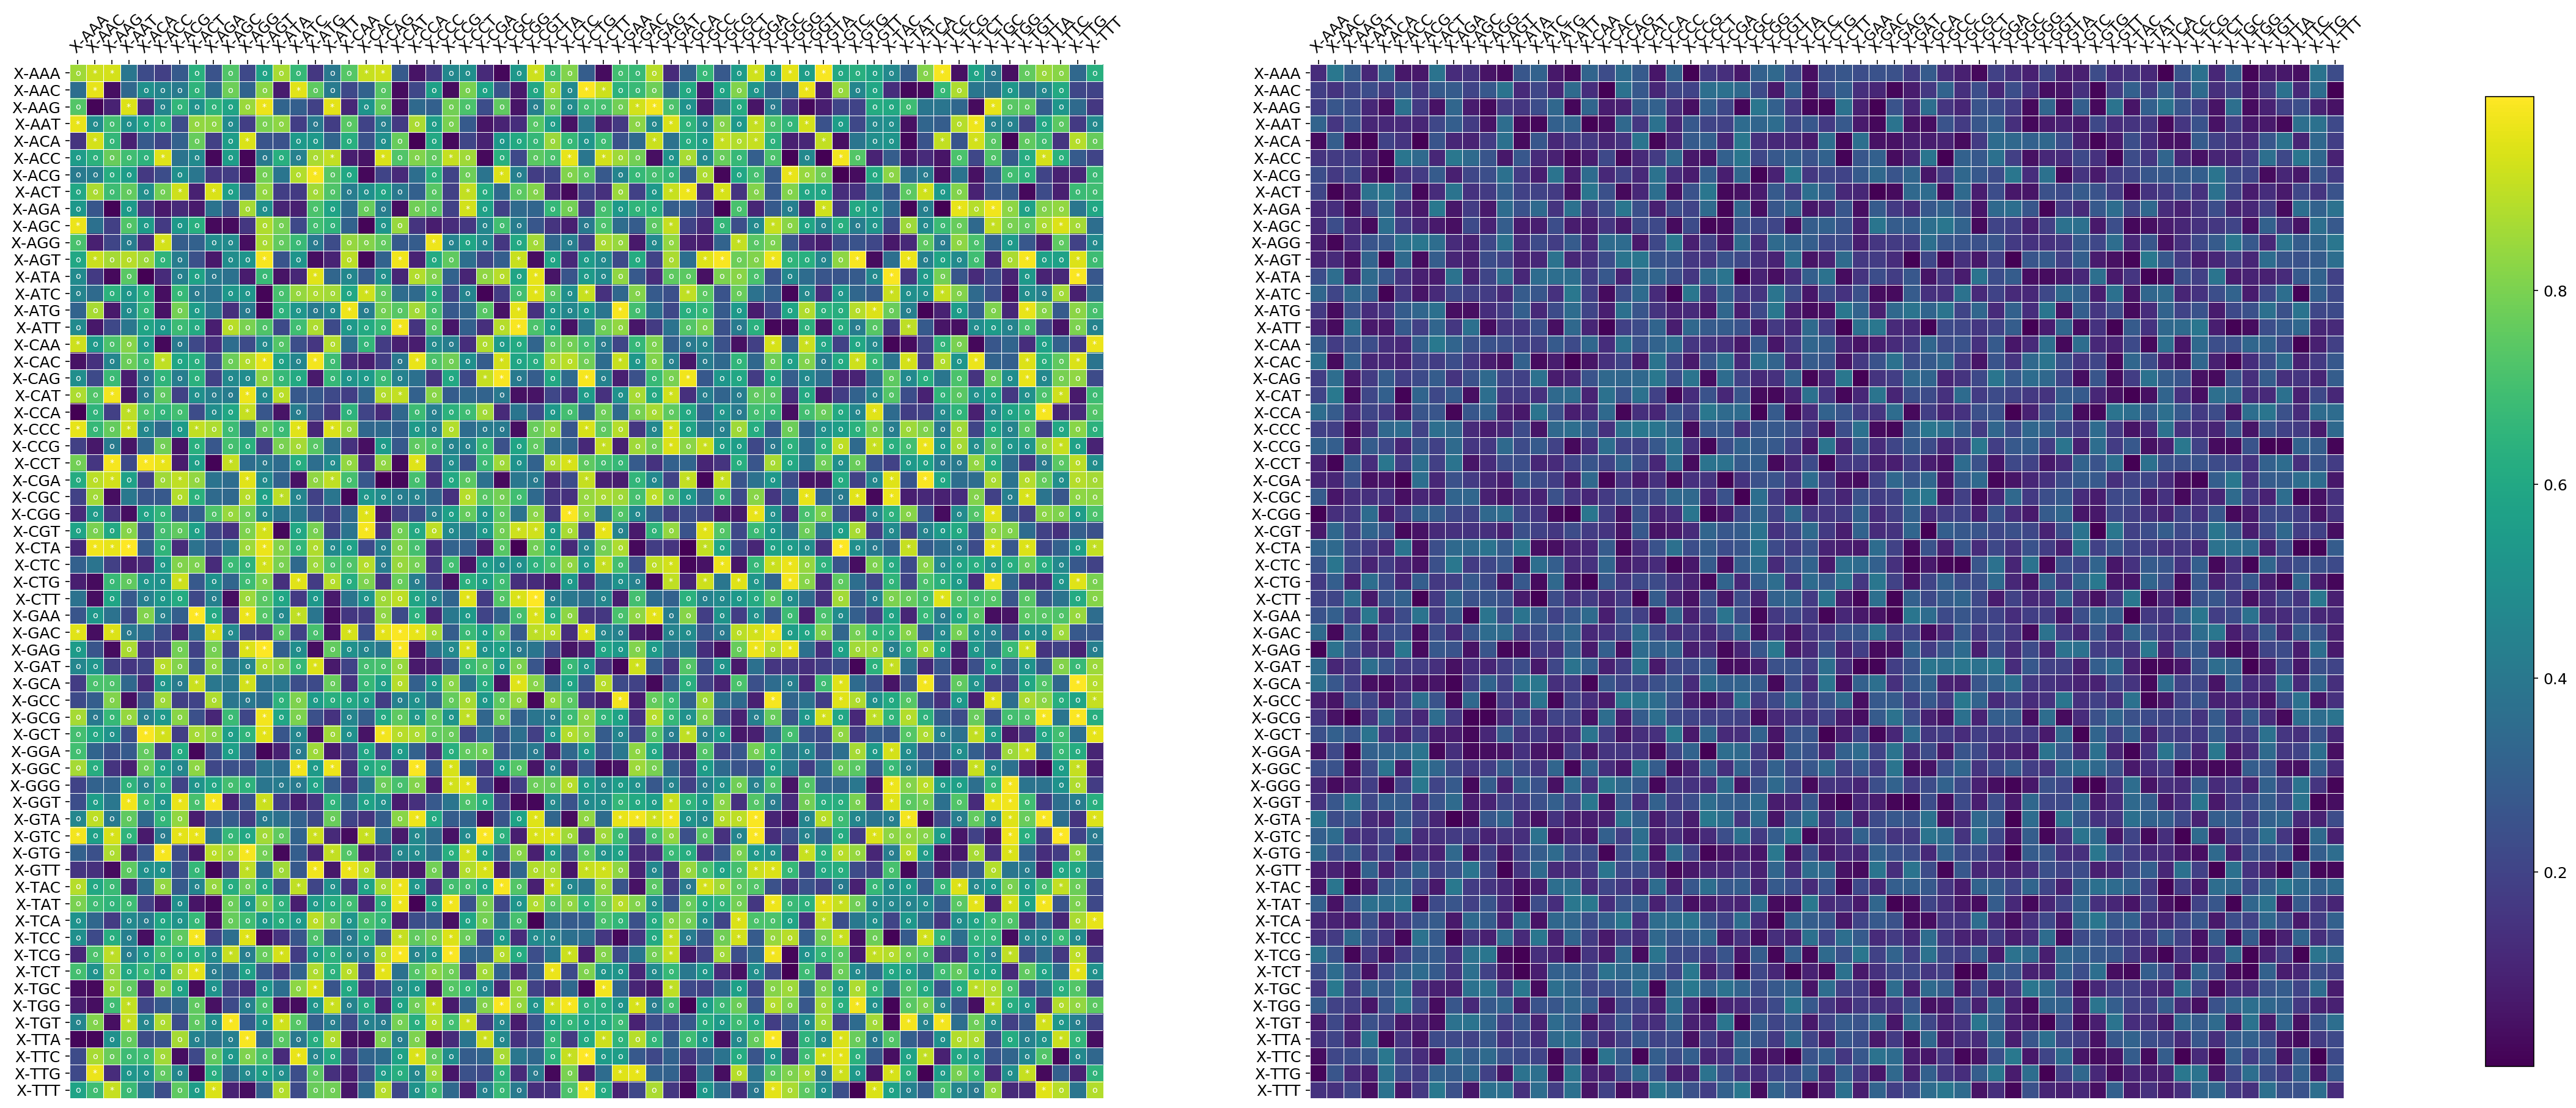

In [90]:
import pp5.plot as plot

d2 = [
    np.random.uniform(0, 1, (61,61)),
    np.random.uniform(0, 1, (61,61)) * 0.4
]

def ann_fn(i, j, k):
    if d2[i][j,k] > 0.9:
        return '*'
    if d2[i][j,k] > 0.4:
        return 'o'
    return ''

fig, ax = plot.multi_heatmap(d2, CODONS, CODONS, fig_size=20, data_annotation_fn=ann_fn)
fig.savefig(OUT_DIR.joinpath('tmp.png'), format='png', bbox_inches='tight')

(<Figure size 3000x750 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15b931410>)

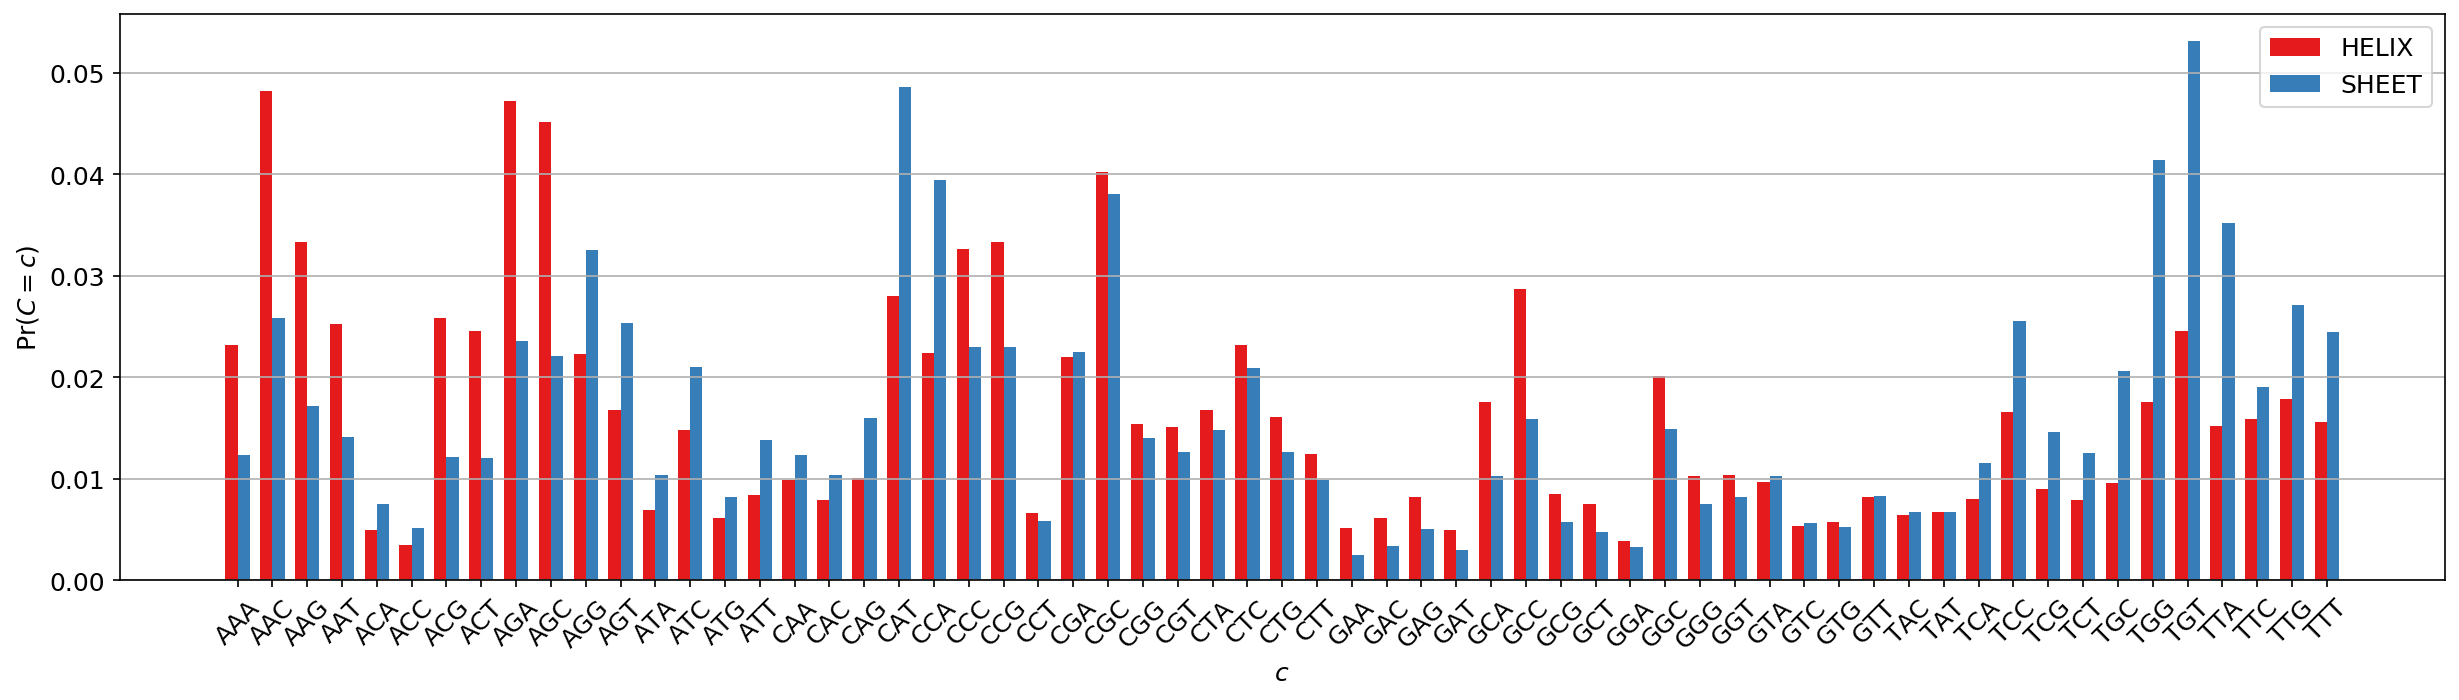

In [73]:
import matplotlib as mpl
import matplotlib.style
import pickle

import pp5.plot

path = OUT_DIR.joinpath('pointwise-cdist/_intermediate_/codon-likelihoods.pkl')

with open(str(path), 'rb') as f:
    codon_likelihoods = pickle.load(f)

for ss_type in codon_likelihoods.keys():
    a = np.array([p for p in codon_likelihoods[ss_type].values()], dtype=np.float32)
    codon_likelihoods[ss_type] = a

pp5.plot.multi_bar(codon_likelihoods, CODONS,
                   ylabel=r'$\Pr(C=c)$', xlabel='$c$', fig_size=(20, 5),
                   single_width=1., total_width=0.7,)


In [39]:
import itertools as it

from cycler import cycler
set1_colors = ['%02x%02x%02x' % tuple(np.int32((np.array(c)*255))) for c in plt.cm.Set1.colors]
set1_colors
# set1_colors

['e41a1c',
 '377eb8',
 '4daf4a',
 '984ea3',
 'ff7f00',
 'ffff33',
 'a65628',
 'f781bf',
 '999999']

In [68]:

plt.cm.get_cmap('Set2').colors
plt.cm.Set1